### RNN을 활용한 문장 생성

이전 Post **<a href="https://wjddyd66.github.io/dl/2019/09/10/LSTM.html">LSTM</a>**에서는 2가지의 Model을 생성하였다.  
1. LSTM Model(Rnnlm)
2. 개선된 LSTM Model(Better Rnnlm): Layer Depth 증가, Dropout, 가중치 공유

위의 2 Model과 **seq2seq**를 활용하여 문장 생성을 하는 것을 목표로 이번 Post를 작성한다.  
먼저 LSTM의 2가지 Model로서 문장 생성을 하기 전에 문장 생성을 하기 위하여 Input Data의 다음 단어를 선택하는 방법에 대해서 생각해 보자.  
2가지 방법이 있다.  
1. **결정적인 방법**: 결정적이란 결과가 하나로 정해지는 것, 결과가 예측가능한 것이다. 즉, 이번 Model에서의 결정적인 방법이란 Input Data에 대한 다음 단어 선택시 **가장 확률이 높은 단어를 선택**하는 것 이다.
2. **확률적인 방법**: 확률적이란 결과가 확률에 따라 정해진다는 것이다. 즉, 이번 Model에서의 확률적인 방법이란 Input Data에 대한 다음 단어 선택 시 **확률에 따라 단어를 선택**하는 것 이다.

이번 2가지의 LSTM을 통하여 생성할 문장은 2번째 방법인 확률적인 방법을 활용한 예시이다.  

먼저 문장생성을 위한 Class부터 정의하면 다음과 같은 Parameter를 가지고 Code는 아래와 같다.  
**문장 생성 Parameter**  
- start_id: 최초로 주는 단어의 ID
- sample_size: 샘플링 하는 단어의 수
- skip_id: 샘플링 되지 않도록 하는 단어의 ID(<
unk>, N 등)
 -<
 unk>: 단어의 수가 적은 단어
 - N: 숫자
 - <
eos>: 문장의 끝을 알려주는 Tag

각각의 Model에 대한 Input Data에 대한 Forward를 Sample_size만큼 수행하여 각 단어에 대한 결과값을 확률적으로 np.random.choice로서 고르는 것으로 수행되는 Code이다.  

In [6]:
from common.functions import softmax
from rnnlm import Rnnlm
from better_rnnlm import BetterRnnlm


class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        return self.lstm_layer.h, self.lstm_layer.c

    def set_state(self, state):
        self.lstm_layer.set_state(*state)


class BetterRnnlmGen(BetterRnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)
            score = self.predict(x).flatten()
            p = softmax(score).flatten()

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))

        return word_ids

    def get_state(self):
        states = []
        for layer in self.lstm_layers:
            states.append((layer.h, layer.c))
        return states

    def set_state(self, states):
        for layer, state in zip(self.lstm_layers, states):
            layer.set_state(*state)

In [7]:
# coding: utf-8
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')

print('Train X Model 결과')
print(txt)
print('-'*50)

model = RnnlmGen()
model.load_params('Rnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')

print('LSTM Model 결과')
print(txt)

Train X Model 결과
you resume broker management-led dealer reflect realized machine year attorney dominate dream manitoba legg message 19th foundation midyear familiar chemical burgess unveiled silly wherever reminder owned newsweek found complaining says stock-market will tumbled declare what gould terrible sri casting owes lancaster lifting conform admitted subsidize telephones tons renamed gear mrs. town broad operated talk takeovers muscle refining printing illinois hoped mitterrand honecker anti-abortion ask pose a.m. affects government-owned bank-holding badly pits package pleasure sustained damp commonly first-time quarterly hall depreciation corporation venture monitor import anger beating sorry narrower items responsible diversify cameras feeling recruited recycled knight hurdles subsidiary d.t. bureaucrats
--------------------------------------------------
LSTM Model 결과
you reading a day in july.
 three minutes later after the program offering to yield to about more than he add

더 낳은 성능을 위해서 개선된 LSTM의 Model을 사용하려했으나 현재 LSTM Model의 Train까지만 확인하고 결과를 저장한 pkl이 없어서 확인 X
=> 빠르게 Train 결과 확인후 돌려고기

In [ ]:
# coding: utf-8
from common.np import *
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)


model = BetterRnnlmGen()
model.load_params('BetterRnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')

print(txt)


model.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

### seq2seq
**seq2seq**는 시계열 데이터를 다른 시계열 데이터로 변환하는 모델이다.  
아래 그림은 seq2seq에 대한 그림이다.  
<div><img src="https://wikidocs.net/images/page/24996/%EC%9D%B8%EC%BD%94%EB%8D%94%EB%94%94%EC%BD%94%EB%8D%94%EB%AA%A8%EB%8D%B8.PNG" height="100%" width="100%" /></div><br>
위의 그림에서도 알 수 있듯이 seq2seq는 크게 2개의 구조로서 이루워져있다.  
Encoder와 Decoder로 이루워져있다.  
먼저 이전 Post에서의 개선된 LSTM의 Model을 형성하기 위하여 가중치 공유에서 Embedding Layer와 Softmax 레이어 사이의 가중치 Matrix를 하나의 가중치 행렬만 사용하는 것을 개인적으로 Encoder, Decoder의 개념으로 생각하였다.  
이러한 Model은 **Input Data를 단어 1개를 Vocab File의 개수크기의 차원으로 One-Hot-Encoding한 Data를 Encoding과 Decoding하는 것**으로서 생각하였다.  

**seq2seq는 이러한 Input Data를 하나의 단어로서 표현하는 것이 아닌 문장으로서 표현하는 것 이다.**  

위의 그림에서 살펴보게 되면 I am a student 라는 문장 Input을 Encoding하여 Context로 변환뒤 Decoder에서 je suis etudiant라고 표현하는 것을 목표로 한다.  

위의 그림에서 중요한 것은 **Text의 경우 Image와 다르게 Data의 길이가 다양한다. 하나의 문장을 구성하는 단어의 개수는 매우 다양하기 때문이다.**  

이러한 Input Data와 Output Data의 문장의 길이가 다르기 때문에 각각의 Encoder와 Decoder에 맞게 문장의 길이를 Padding하는 작업이 필요하다.  
CNN에서도 Image의 차원을 맞춰주기 위하여 Padding을 통하여 Image의 차원을 맞춰주는 작업을 하였다.  

seq2seq의 경우에도 문장의 길이가 각각다르기 때문에 맞춰주기 위하여 Padding의 과정을 거치게 된다.  

seq2seq는 Encoding과 Decoding의 길이에 맞게 각각 다르게 Padding작업을 거치면서 패딩은 의미없는 문자열을 통하여 길이를 맞춰주게 된다.  
이러한 Padding을 통하여 **Text의 특징인 가변길이의 Input Data와 Output Data의 특징을 만족시킬 수 있다.**  

### seq2seq를 통한 덧셈 구현
위에서 설명한 seq2seq를 통하여 덧셈을 구현하는 것을 목표로 한다.  
먼저 Dataset을 살펴보면 아래와 같다.  
<div><img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/AI/102.PNG" height="250" width="600" /></div>
Input Data의 Format을 보게 되면 1 6 + 7 5 가 각각 들어가게 된다.  
Output Data의 Format을 보게 되면 - 9 1 로서 각각 들어가게 된다.  
위의 '_'는 결과를 의미한다.  

위의 DataSet을 통해 최종적으로 구현하고자 하는 Model은 16+75라는 Text가 들어가게 되면 91이라는 Text를 출력하는 것을 목표로하는 Model을 만드는 것 이다.  

Encoder의 구현과 각각의 Parameter를 알아보자.  
**Encoder의 최종적인 목적은 Decoder에 첫번째 입력 상태의 값으로 사용할 Context Vector를 만드는 것이 목표**이다.  
**Encoder Parameter**  
- vocab_size: 어휘 수(0 ~ 9, +, _ => 13가지)
- wordvec_size: 문자 벡터의 차워 수
- hidden_size: LSTM 계층의 은닉 상태 벡터의 차원 수
- hs: Decoder에 첫번째 입력 상태의 값으로 사용할 Context Vector

In [8]:
from common.time_layers import *
from common.base_model import BaseModel


class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

Decoder의 구현과 각각의 Parameter를 알아보자.  
**Decoder의 최종적인 목적은 Context Vector를 Hidden Layer의 첫번째 입력값으로 받아서 정답을 출력하는 것이 목표**이다.  
또한 정답인 것으로 알리는 문자열인 [_]를 기준으로 [_,6,2]가 들어오게 되면 62를 출력하도록 출력하는 것이 목표이다.  

또한 위에서 언급한 **결정적과 확률적인 방법중 결정적인 방법을 사용하게 된다.**  
덧셈의 경우 문장에서 단어 선택과 달리 확실한 정답이 정해져 있으므로 결정적인 방법을 사용한다.  
이러한 방식은 Argmax를 사용하여 가장 높은 값을 선택하는 것으로서 구현되었다.  

In [9]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled

위에서 선언한 Encoder, Decoder Class를 통하여 seq2seq Class를 구성한다.  
아래 seq2seq Model 은 Encoder 와 Decoder 그리고 Loss를 계산하기 위한 Time Softmax with Loss로서 구성되어있다.  

In [10]:
class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq



# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('에폭')
plt.ylabel('정확도')
plt.ylim(0, 1.0)
plt.show()



| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 2[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 3[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 3[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 4[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 4[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 5[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 6[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 6[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 7[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 7[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 8[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 8[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 9[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 9[s] | 손실 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1000
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1000
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---
Q 26+838

Q 77+85  
T 162 
X 158 
---
Q 975+164
T 1139
X 1108
---
Q 582+84 
T 666 
X 660 
---
Q 8+155  
T 163 
X 164 
---
Q 367+55 
T 422 
X 411 
---
Q 600+257
T 857 
X 838 
---
Q 761+292
T 1053
X 1009
---
Q 830+597
T 1427
X 1410
---
Q 26+838 
T 864 
X 868 
---
Q 143+93 
T 236 
X 207 
---
검증 정확도 3.880%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.98
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 1.00
| 에폭 9 |  반복 41 / 351 | 시간 1[s] | 손실 0.99
| 에폭 9 |  반복 61 / 351 | 시간 1[s] | 손실 0.99
| 에폭 9 |  반복 81 / 351 | 시간 2[s] | 손실 1.00
| 에폭 9 |  반복 101 / 351 | 시간 3[s] | 손실 0.99
| 에폭 9 |  반복 121 / 351 | 시간 3[s] | 손실 1.00
| 에폭 9 |  반복 141 / 351 | 시간 4[s] | 손실 0.99
| 에폭 9 |  반복 161 / 351 | 시간 4[s] | 손실 1.01
| 에폭 9 |  반복 181 / 351 | 시간 5[s] | 손실 0.98
| 에폭 9 |  반복 201 / 351 | 시간 5[s] | 손실 0.99
| 에폭 9 |  반복 221 / 351 | 시간 6[s] | 손실 1.00
| 에폭 9 |  반복 241 / 351 | 시간 7[s] | 손실 0.98
| 에폭 9 |  반복 261 / 351 | 시간 7[s] | 손실 0.99
| 에폭 9 |  반복 281 / 351 | 시간 8[s] | 손실 0.99
| 에폭 9 |  반복 301 / 351 | 시간 9[s] | 손실 0.98
| 에폭 9 |  반복 321 / 351 |

| 에폭 16 |  반복 181 / 351 | 시간 4[s] | 손실 0.86
| 에폭 16 |  반복 201 / 351 | 시간 5[s] | 손실 0.84
| 에폭 16 |  반복 221 / 351 | 시간 5[s] | 손실 0.85
| 에폭 16 |  반복 241 / 351 | 시간 6[s] | 손실 0.86
| 에폭 16 |  반복 261 / 351 | 시간 7[s] | 손실 0.88
| 에폭 16 |  반복 281 / 351 | 시간 7[s] | 손실 0.87
| 에폭 16 |  반복 301 / 351 | 시간 8[s] | 손실 0.85
| 에폭 16 |  반복 321 / 351 | 시간 8[s] | 손실 0.91
| 에폭 16 |  반복 341 / 351 | 시간 9[s] | 손실 0.87
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
X 1124
---
Q 582+84 
T 666 
X 662 
---
Q 8+155  
T 163 
X 167 
---
Q 367+55 
T 422 
X 419 
---
Q 600+257
T 857 
X 856 
---
Q 761+292
T 1053
X 1049
---
Q 830+597
T 1427
X 1424
---
Q 26+838 
T 864 
X 859 
---
Q 143+93 
T 236 
X 239 
---
검증 정확도 6.880%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.85
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.87
| 에폭 17 |  반복 41 / 351 | 시간 1[s] | 손실 0.87
| 에폭 17 |  반복 61 / 351 | 시간 1[s] | 손실 0.87
| 에폭 17 |  반복 81 / 351 | 시간 2[s] | 손실 0.85
| 에폭 17 |  반복 101 / 351 | 시간 2[s] | 손실 0.85
| 에폭 17 |  반복 121 / 351 | 시간 3[s] | 손실 0.85
| 에폭 17 

검증 정확도 4.800%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.80
| 에폭 24 |  반복 21 / 351 | 시간 0[s] | 손실 0.83
| 에폭 24 |  반복 41 / 351 | 시간 1[s] | 손실 0.81
| 에폭 24 |  반복 61 / 351 | 시간 1[s] | 손실 0.80
| 에폭 24 |  반복 81 / 351 | 시간 2[s] | 손실 0.79
| 에폭 24 |  반복 101 / 351 | 시간 2[s] | 손실 0.76
| 에폭 24 |  반복 121 / 351 | 시간 3[s] | 손실 0.77
| 에폭 24 |  반복 141 / 351 | 시간 3[s] | 손실 0.78
| 에폭 24 |  반복 161 / 351 | 시간 4[s] | 손실 0.78
| 에폭 24 |  반복 181 / 351 | 시간 4[s] | 손실 0.81
| 에폭 24 |  반복 201 / 351 | 시간 5[s] | 손실 0.80
| 에폭 24 |  반복 221 / 351 | 시간 5[s] | 손실 0.79
| 에폭 24 |  반복 241 / 351 | 시간 6[s] | 손실 0.77
| 에폭 24 |  반복 261 / 351 | 시간 6[s] | 손실 0.79
| 에폭 24 |  반복 281 / 351 | 시간 7[s] | 손실 0.78
| 에폭 24 |  반복 301 / 351 | 시간 7[s] | 손실 0.78
| 에폭 24 |  반복 321 / 351 | 시간 8[s] | 손실 0.76
| 에폭 24 |  반복 341 / 351 | 시간 8[s] | 손실 0.80
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
X 1137
---
Q 582+84 
T 666 
X 661 
---
Q 8+155  
T 163 
X 157 
---
Q 367+55 
T 422 
X 421 
---
Q 600+257
T 857 
X 849 
---
Q 761+292
T 1053
X 1049
---
Q 83

<Figure size 640x480 with 1 Axes>

결과 시각화 하기

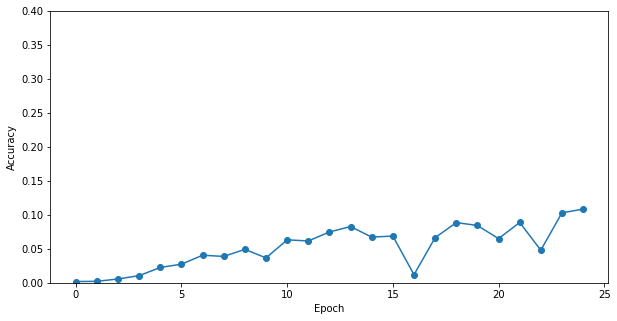

In [13]:
# 그래프 그리기
plt.figure(figsize=(10,5))
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 0.4)
plt.show()

### 개선된 seq2seq
위의 결과가 11%정도로 매우 낮아 개선할 수 있는 2가지 방법에 대해 살펴보자  

먼저 **Input Data의 반전**이 있다.  
대부분의 Input Data의 차원을 맞춰주기 위하여 Padding을 활용하여 Input Data의 차원을 맞춰주게 된다.  
이러한 결과로서 Input Data의 뒷부분에는 Padding을 의미하는 문자열이 들어가게 된다.  
**RNN의 Long Term Dependency를 해결하기 위하여 LSTM을 사용하였지만 Input Data의 의미있는 Data가 결국에는 가장 마지막에 들어와서 Forget Gate를 덜 거치는 것이 결과가 좋을 것이라는 것은 당연하다고 생각할 수 있다.**  
참고사항으로 Google은 다음과 같이 자신들이 만든 생성형 문서 요약 Model에서 설명하였다.  
>One approach to summarization is to extract parts of the document that are deemed interesting by some metric (for example, inverse-document frequency) and join them to form a summary. Algorithms of this flavor are called extractive summarization.

**개인적인 생각으로는 영어의 경우 1 ~ 5형식으로서 문장이 이루워진다.  
이에 관하여 문장에서 가장 중요한 것은 주어와 동사라고 할 수 있다.  
모든 문장에서 주어와 동사는 가장 앞에 나오므로 문장의 순서를 거꾸로 하여 Input Data로서 사용하였을 때 Model의 성능이 향상될 것이라는 것은 예상할 수 있다.**  
참고: <a href="https://ai.googleblog.com/2016/08/text-summarization-with-tensorflow.html">Google Text Summarization</a><br>
**이번 Model에서는 문장의 구조와는 상관 없지만 Padding의 문자열이 마지막에 들어가서 Forget Gate를 덜 거치는 것 보다 의미 있는 데이터가 가장 마지막에 들어감으로써 Forget Gate를 덜 거치는 것이 Model의 성능을 향상시킬 것이라고 예상할 수 있다.**  

In [15]:
# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
model = Seq2seq(vocab_size, wordvec_size, hideen_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list2 = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list2.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.52
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.91
| 에폭 1 |  반복 101 / 351 | 시간 2[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 3[s] | 손실 1.86
| 에폭 1 |  반복 141 / 351 | 시간 3[s] | 손실 1.84
| 에폭 1 |  반복 161 / 351 | 시간 4[s] | 손실 1.80
| 에폭 1 |  반복 181 / 351 | 시간 4[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 5[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 5[s] | 손실 1.77
| 에폭 1 |  반복 241 / 351 | 시간 6[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 7[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 7[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 8[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 8[s] | 손실 1.74
| 에폭 1 |  반복 341 / 351 | 시간 9[s] | 손실 1.73
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1001
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1001
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---
Q 26+838

Q 77+85  
T 162 
X 163 
---
Q 975+164
T 1139
X 1134
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
X 162 
---
Q 367+55 
T 422 
X 423 
---
Q 600+257
T 857 
X 759 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
X 1431
---
Q 26+838 
T 864 
X 866 
---
Q 143+93 
T 236 
X 238 
---
검증 정확도 23.080%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.55
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 0.56
| 에폭 9 |  반복 41 / 351 | 시간 1[s] | 손실 0.56
| 에폭 9 |  반복 61 / 351 | 시간 1[s] | 손실 0.55
| 에폭 9 |  반복 81 / 351 | 시간 2[s] | 손실 0.54
| 에폭 9 |  반복 101 / 351 | 시간 2[s] | 손실 0.55
| 에폭 9 |  반복 121 / 351 | 시간 3[s] | 손실 0.55
| 에폭 9 |  반복 141 / 351 | 시간 3[s] | 손실 0.54
| 에폭 9 |  반복 161 / 351 | 시간 4[s] | 손실 0.55
| 에폭 9 |  반복 181 / 351 | 시간 4[s] | 손실 0.53
| 에폭 9 |  반복 201 / 351 | 시간 5[s] | 손실 0.54
| 에폭 9 |  반복 221 / 351 | 시간 6[s] | 손실 0.54
| 에폭 9 |  반복 241 / 351 | 시간 6[s] | 손실 0.53
| 에폭 9 |  반복 261 / 351 | 시간 7[s] | 손실 0.53
| 에폭 9 |  반복 281 / 351 | 시간 7[s] | 손실 0.54
| 에폭 9 |  반복 301 / 351 | 시간 8[s] | 손실 0.54
| 에폭 9 |  반복 321 / 351 

| 에폭 16 |  반복 181 / 351 | 시간 5[s] | 손실 0.36
| 에폭 16 |  반복 201 / 351 | 시간 5[s] | 손실 0.38
| 에폭 16 |  반복 221 / 351 | 시간 6[s] | 손실 0.38
| 에폭 16 |  반복 241 / 351 | 시간 6[s] | 손실 0.36
| 에폭 16 |  반복 261 / 351 | 시간 7[s] | 손실 0.35
| 에폭 16 |  반복 281 / 351 | 시간 7[s] | 손실 0.35
| 에폭 16 |  반복 301 / 351 | 시간 8[s] | 손실 0.35
| 에폭 16 |  반복 321 / 351 | 시간 9[s] | 손실 0.35
| 에폭 16 |  반복 341 / 351 | 시간 9[s] | 손실 0.37
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
X 1142
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
X 858 
---
Q 761+292
T 1053
X 1054
---
Q 830+597
T 1427
X 1430
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
X 237 
---
검증 정확도 42.700%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.34
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.36
| 에폭 17 |  반복 41 / 351 | 시간 1[s] | 손실 0.36
| 에폭 17 |  반복 61 / 351 | 시간 1[s] | 손실 0.35
| 에폭 17 |  반복 81 / 351 | 시간 2[s] | 손실 0.36
| 에폭 17 |  반복 101 / 351 | 시간 2[s] | 손실 0.34
| 에폭 17 |  반복 121 / 351 | 시간 3[s] | 손실 0.34
| 에폭 17

검증 정확도 45.160%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.31
| 에폭 24 |  반복 21 / 351 | 시간 0[s] | 손실 0.29
| 에폭 24 |  반복 41 / 351 | 시간 1[s] | 손실 0.28
| 에폭 24 |  반복 61 / 351 | 시간 1[s] | 손실 0.29
| 에폭 24 |  반복 81 / 351 | 시간 2[s] | 손실 0.30
| 에폭 24 |  반복 101 / 351 | 시간 2[s] | 손실 0.29
| 에폭 24 |  반복 121 / 351 | 시간 3[s] | 손실 0.29
| 에폭 24 |  반복 141 / 351 | 시간 3[s] | 손실 0.29
| 에폭 24 |  반복 161 / 351 | 시간 4[s] | 손실 0.28
| 에폭 24 |  반복 181 / 351 | 시간 5[s] | 손실 0.29
| 에폭 24 |  반복 201 / 351 | 시간 5[s] | 손실 0.28
| 에폭 24 |  반복 221 / 351 | 시간 6[s] | 손실 0.28
| 에폭 24 |  반복 241 / 351 | 시간 6[s] | 손실 0.29
| 에폭 24 |  반복 261 / 351 | 시간 7[s] | 손실 0.29
| 에폭 24 |  반복 281 / 351 | 시간 7[s] | 손실 0.29
| 에폭 24 |  반복 301 / 351 | 시간 8[s] | 손실 0.28
| 에폭 24 |  반복 321 / 351 | 시간 9[s] | 손실 0.27
| 에폭 24 |  반복 341 / 351 | 시간 9[s] | 손실 0.29
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
X 421 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
X 1054
---
Q 8

입력 데이터 반전 시각화

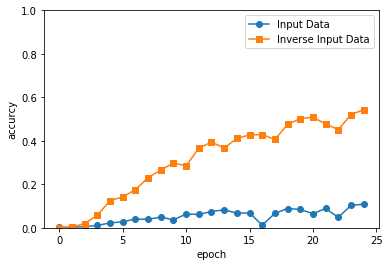

In [18]:
# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o',label='Input Data')
plt.plot(x, acc_list2, marker='s',label='Inverse Input Data')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accurcy')
plt.ylim(0, 1.0)
plt.show()

두번째의 방법은 Peeky이다.  
Peeky는 엿보기라는 의미로서 Decoder의 첫 번째 Hidden Layer로 들어가는 Context Vector를 활용하는 것 이다.  
Context Vector는 Decoder에게 필요한 정보가 모두 담겨있다.  
이러한 Context Vector를 첫번째 Hidden Layer의 Input으로만 사용하지 않고 각각의 LSTM의 Input과 Affine 계층의 Input으로서 사용한다는 의미이다.  
최종적인 Peeky를 사용한 Model의 구성은 아래 그림과 같다.  

<div><img src="https://raw.githubusercontent.com/wjddyd66/wjddyd66.github.io/master/static/img/AI/105.PNG" height="250" width="600" /></div>
<br>
위의 그림을 Code로서 표현하면 아래와 같다.  

아래 Code와 기존 Model에서 달라진 점을 알아보면 다음과 같다.  
lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')  
affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')  
각각의 LSTM Layer와 Affine Layer에 Context Vector가 추가되므로 차원을 늘려주는 과정을 거쳐야 된다.  
hs = np.repeat(h, T, axis=0).reshape(N, T, H)  
out = np.concatenate((hs, out), axis=2)  
out = np.concatenate((hs, out), axis=2)  
np.concatenate를 통하여 Input 으로 들어오는 Context Vector or Output 과 Input Data를 합쳐주는 과정을 거쳐야 된다.  

In [20]:
from common.time_layers import *


class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled


class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

최종적인 Inverse Input Data와 Peeky를 사용하였을때의 결과는 아래와 같다.  

In [21]:
# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 반전 여부 설정 =============================================
is_reverse = True  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 일반 혹은 엿보기(Peeky) 설정 =====================================
# model = Seq2seq(vocab_size, wordvec_size, hideen_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list3 = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list3.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 0[s] | 손실 2.48
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 1[s] | 손실 1.99
| 에폭 1 |  반복 81 / 351 | 시간 2[s] | 손실 1.89
| 에폭 1 |  반복 101 / 351 | 시간 3[s] | 손실 1.82
| 에폭 1 |  반복 121 / 351 | 시간 3[s] | 손실 1.82
| 에폭 1 |  반복 141 / 351 | 시간 4[s] | 손실 1.80
| 에폭 1 |  반복 161 / 351 | 시간 5[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 5[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 6[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 7[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 7[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 8[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 9[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 9[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 10[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 10[s] | 손실 1.73
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1013
---
Q 582+84 
T 666 
X 102 
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1023
---
Q 600+257
T 857 
X 1023
---
Q 761+292
T 1053
X 1023
---
Q 830+597
T 1427
X 1111
---
Q 26+8

Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
X 657 
---
Q 8+155  
T 163 
X 155 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
X 1438
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 65.060%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.32
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 0.31
| 에폭 9 |  반복 41 / 351 | 시간 1[s] | 손실 0.31
| 에폭 9 |  반복 61 / 351 | 시간 1[s] | 손실 0.31
| 에폭 9 |  반복 81 / 351 | 시간 2[s] | 손실 0.29
| 에폭 9 |  반복 101 / 351 | 시간 3[s] | 손실 0.29
| 에폭 9 |  반복 121 / 351 | 시간 3[s] | 손실 0.29
| 에폭 9 |  반복 141 / 351 | 시간 4[s] | 손실 0.27
| 에폭 9 |  반복 161 / 351 | 시간 5[s] | 손실 0.27
| 에폭 9 |  반복 181 / 351 | 시간 5[s] | 손실 0.26
| 에폭 9 |  반복 201 / 351 | 시간 6[s] | 손실 0.25
| 에폭 9 |  반복 221 / 351 | 시간 6[s] | 손실 0.25
| 에폭 9 |  반복 241 / 351 | 시간 7[s] | 손실 0.24
| 에폭 9 |  반복 261 / 351 | 시간 8[s] | 손실 0.24
| 에폭 9 |  반복 281 / 351 | 시간 8[s] | 손실 0.23
| 에폭 9 |  반복 301 / 351 | 시간 9[s] | 손실 0.22
| 에폭 9 |  반복 321 / 351 

| 에폭 16 |  반복 161 / 351 | 시간 5[s] | 손실 0.04
| 에폭 16 |  반복 181 / 351 | 시간 6[s] | 손실 0.04
| 에폭 16 |  반복 201 / 351 | 시간 6[s] | 손실 0.04
| 에폭 16 |  반복 221 / 351 | 시간 7[s] | 손실 0.04
| 에폭 16 |  반복 241 / 351 | 시간 8[s] | 손실 0.04
| 에폭 16 |  반복 261 / 351 | 시간 8[s] | 손실 0.04
| 에폭 16 |  반복 281 / 351 | 시간 9[s] | 손실 0.04
| 에폭 16 |  반복 301 / 351 | 시간 10[s] | 손실 0.04
| 에폭 16 |  반복 321 / 351 | 시간 11[s] | 손실 0.04
| 에폭 16 |  반복 341 / 351 | 시간 11[s] | 손실 0.04
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
X 162 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q 830+597
T 1427
O 1427
---
Q 26+838 
T 864 
O 864 
---
Q 143+93 
T 236 
O 236 
---
검증 정확도 94.780%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.05
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.04
| 에폭 17 |  반복 41 / 351 | 시간 1[s] | 손실 0.04
| 에폭 17 |  반복 61 / 351 | 시간 2[s] | 손실 0.04
| 에폭 17 |  반복 81 / 351 | 시간 3[s] | 손실 0.03
| 에폭 17 |  반복 101 / 351 | 시간 5[s] | 손실 0.03
| 에폭

검증 정확도 98.020%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.01
| 에폭 24 |  반복 21 / 351 | 시간 0[s] | 손실 0.01
| 에폭 24 |  반복 41 / 351 | 시간 1[s] | 손실 0.01
| 에폭 24 |  반복 61 / 351 | 시간 1[s] | 손실 0.02
| 에폭 24 |  반복 81 / 351 | 시간 2[s] | 손실 0.02
| 에폭 24 |  반복 101 / 351 | 시간 3[s] | 손실 0.02
| 에폭 24 |  반복 121 / 351 | 시간 3[s] | 손실 0.03
| 에폭 24 |  반복 141 / 351 | 시간 4[s] | 손실 0.02
| 에폭 24 |  반복 161 / 351 | 시간 5[s] | 손실 0.02
| 에폭 24 |  반복 181 / 351 | 시간 5[s] | 손실 0.02
| 에폭 24 |  반복 201 / 351 | 시간 6[s] | 손실 0.01
| 에폭 24 |  반복 221 / 351 | 시간 7[s] | 손실 0.01
| 에폭 24 |  반복 241 / 351 | 시간 7[s] | 손실 0.01
| 에폭 24 |  반복 261 / 351 | 시간 8[s] | 손실 0.01
| 에폭 24 |  반복 281 / 351 | 시간 8[s] | 손실 0.01
| 에폭 24 |  반복 301 / 351 | 시간 9[s] | 손실 0.01
| 에폭 24 |  반복 321 / 351 | 시간 10[s] | 손실 0.02
| 에폭 24 |  반복 341 / 351 | 시간 10[s] | 손실 0.02
Q 77+85  
T 162 
O 162 
---
Q 975+164
T 1139
O 1139
---
Q 582+84 
T 666 
O 666 
---
Q 8+155  
T 163 
O 163 
---
Q 367+55 
T 422 
O 422 
---
Q 600+257
T 857 
O 857 
---
Q 761+292
T 1053
O 1053
---
Q

최종 결과 시각화

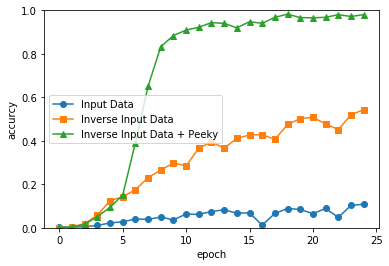

In [22]:
# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o',label='Input Data')
plt.plot(x, acc_list2, marker='s',label='Inverse Input Data')
plt.plot(x, acc_list3, marker='^',label='Inverse Input Data + Peeky')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accurcy')
plt.ylim(0, 1.0)
plt.show()